# A notebook to plot a nice representation of H20 with our embeddings as an example

In [1]:
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


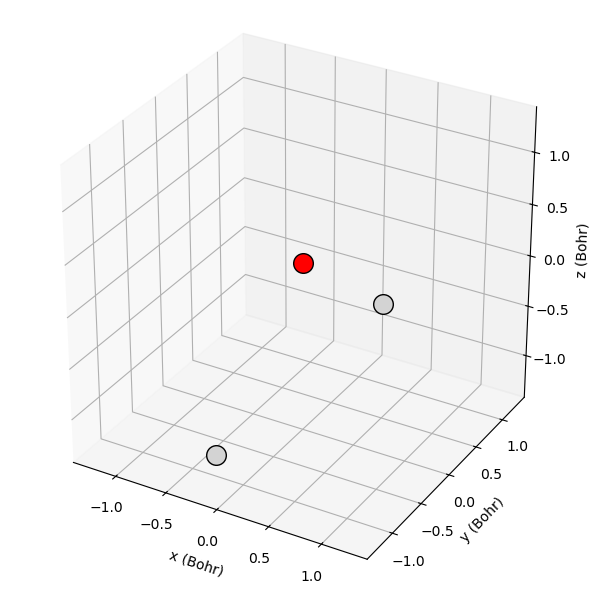

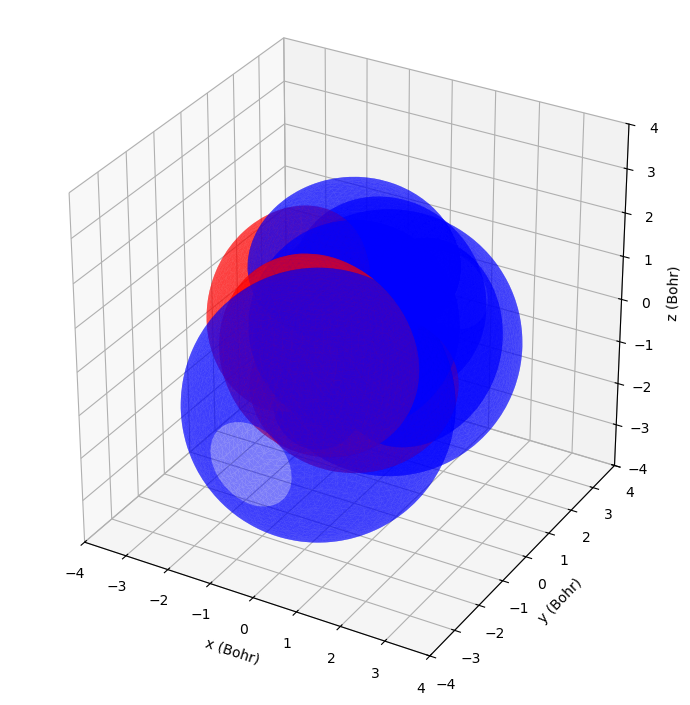

In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# Filename: atomic_vs_mo_plot.py
#
# - plot_molecule_mpl: ball‐and‐stick rendering of an XYZ molecule
# - plot_atomic_orbitals_mpl: atomic‐orbital isosurfaces (s, p, d, f) for specified atoms
#
# Dependencies:
#   pip install numpy matplotlib pyscf scipy scikit-image
# ──────────────────────────────────────────────────────────────────────────────

import re
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from pyscf import gto, scf
from pyscf.scf.hf import init_guess_by_minao
from scipy.linalg import eigh
from skimage.measure import marching_cubes

# ─── HELPERS ─────────────────────────────────────────────────────────────────

def read_xyz_bohr(xyz_file):
    """Read a .xyz (Å) → list of (symbol, (x,y,z) in Bohr)."""
    ang2bohr = 1.0/0.529177
    with open(xyz_file) as f:
        lines = f.readlines()
    geom = []
    for line in lines[2:2+int(lines[0])]:
        sym, *coords = line.split()
        xyz = tuple(float(c)*ang2bohr for c in coords)
        geom.append((sym, xyz))
    return geom

def build_mol(geom, basis='cc-pVDZ'):
    """Construct a PySCF Mole (in Bohr units) from geom list."""
    atom_str = "\n".join(f"{s} {x} {y} {z}" for s,(x,y,z) in geom)
    mol = gto.Mole()
    mol.unit  = 'Bohr'
    mol.atom  = atom_str
    mol.basis = basis
    mol.build()
    return mol

def make_grid(npts=60, box=4.0):
    """Return X, Y, Z mesh plus flattened pts over a [-box,box]^3 grid."""
    lin = np.linspace(-box, box, npts)
    X, Y, Z = np.meshgrid(lin, lin, lin, indexing='ij')
    pts = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T
    return X, Y, Z, pts

def eval_on_grid(mol, coeff, pts, shape):
    """Evaluate MO/AO (given by coeff vector) on pts, reshape to shape."""
    ao = mol.eval_gto('GTOval', pts)   # (npts^3, nbf)
    psi = ao.dot(coeff)                # (npts^3,)
    return psi.reshape(shape)

# ─── PLOT 1: BALL‐AND‐STICK ───────────────────────────────────────────────────

def plot_molecule_mpl(geom,
                      atom_colors={'H':'lightgrey','O':'red'},
                      bond_cutoff=2.0):
    """
    Draw atoms as colored spheres and O–H bonds as sticks.
    geom: list of (symbol, (x,y,z)) in Bohr
    bond_cutoff: max O–H bond length (Bohr)
    """
    symbols = [s for s,_ in geom]
    coords  = np.array([xyz for _,xyz in geom])
    fig = plt.figure(figsize=(6,6))
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect((1,1,1))
    # atoms
    for sym,(x,y,z) in zip(symbols, coords):
        c = atom_colors.get(sym, 'lightblue')
        ax.scatter([x],[y],[z], color=c, s=200, edgecolor='k', depthshade=True)
    # bonds
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            si, sj = symbols[i], symbols[j]
            if {si,sj}=={'O','H'}:
                p, q = coords[i], coords[j]
                if np.linalg.norm(p-q) < bond_cutoff:
                    ax.plot(*zip(p,q), color='grey', linewidth=3)
    # limits & labels
    mn, mx = coords.min(), coords.max()
    ax.set_xlim(mn,mx); ax.set_ylim(mn,mx); ax.set_zlim(mn,mx)
    ax.set_xlabel('x (Bohr)'); ax.set_ylabel('y (Bohr)'); ax.set_zlabel('z (Bohr)')
    plt.tight_layout(); plt.show()

# ─── PLOT 2: ATOMIC ORBITALS ─────────────────────────────────────────────────

def plot_atomic_orbitals_mpl(mol, geom, atom_orb_dict,
                             X, Y, Z, pts,
                             iso_frac=0.2,
                             facecolor_pos='blue',
                             facecolor_neg='red'):
    """
    Plot atomic basis‐function isosurfaces for specified atoms & L‐types.
    atom_orb_dict: e.g. {'O1':['s','p'], 'H2':['s']}
    X,Y,Z,pts: grid from make_grid()
    iso_frac: fraction of each AO's peak |ψ| to contour
    """
    # prep grid info
    npts = X.shape[0]
    box  = float(X.max())
    step = (2*box)/(npts-1)
    origin = np.array([float(X.min()), float(Y.min()), float(Z.min())])

    # evaluate all AOs once
    ao_vals = mol.eval_gto('GTOval', pts)  # (npts^3, nbf)

    # use aoslice_by_atom to map atom→ao index range
    aoslice = mol.aoslice_by_atom()        # shape (natm,4)
    # build atom_id (e.g. "O1","H1") ↔ atom index
    atom_syms = [mol.atom_symbol(i) for i in range(mol.natm)]
    counts = {}
    id_to_idx = {}
    for ia, sym in enumerate(atom_syms):
        counts[sym] = counts.get(sym,0) + 1
        atom_id = f"{sym}{counts[sym]}"
        id_to_idx[atom_id] = ia

    # AO labels → angular type
    ao_labels = mol.ao_labels()
    ao_types  = [re.search(r'([spdf])', lab.split()[-1].lower()).group(1)
                 for lab in ao_labels]

    # set up figure
    fig = plt.figure(figsize=(7,7))
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect((1,1,1))

    # loop requested atoms
    for atom_id, types_wanted in atom_orb_dict.items():
        if atom_id not in id_to_idx:
            print(f"Warning: atom {atom_id} not in geometry.")
            continue
        ia = id_to_idx[atom_id]
        a0,_, ao0, ao1 = aoslice[ia]  # start/end indices for AOs

        for j in range(ao0, ao1):
            L = ao_types[j]
            if L not in types_wanted:
                continue
            grid = ao_vals[:, j].reshape(X.shape)
            vmin, vmax = float(grid.min()), float(grid.max())
            absmax = max(abs(vmin), abs(vmax))
            iso = iso_frac * absmax

            # positive lobe
            if iso <= vmax:
                verts, faces, _, _ = marching_cubes(
                    grid, level=iso,
                    spacing=(step,step,step))
                verts += origin
                mesh = Poly3DCollection(
                    verts[faces],
                    facecolor=facecolor_pos,
                    alpha=0.5, edgecolor='none')
                ax.add_collection3d(mesh)
            # negative lobe
            if -iso >= vmin:
                verts2, faces2, _, _ = marching_cubes(
                    grid, level=-iso,
                    spacing=(step,step,step))
                verts2 += origin
                mesh2 = Poly3DCollection(
                    verts2[faces2],
                    facecolor=facecolor_neg,
                    alpha=0.5, edgecolor='none')
                ax.add_collection3d(mesh2)

    # scatter nuclei for context
    coords = np.array([xyz for _,xyz in geom])
    ax.scatter(coords[:,0], coords[:,1], coords[:,2],
               color='k', s=80)

    # limits & labels
    mn, mx = float(X.min()), float(X.max())
    ax.set_xlim(mn,mx); ax.set_ylim(mn,mx); ax.set_zlim(mn,mx)
    ax.set_xlabel('x (Bohr)'); ax.set_ylabel('y (Bohr)'); ax.set_zlabel('z (Bohr)')
    plt.tight_layout(); plt.show()
if __name__ == '__main__':
    # 1) Parameters
    xyz_path    = 'plot_data/h2o.xyz'  # path to XYZ file (Å)
    basis       = '6-31G'          # basis set (e.g. 'cc-pVDZ', '6-31G')
    bond_cutoff = 2.0      # in Bohr (~1.06 Å)
    npts, box   = 60, 4.0  # grid resolution & half‐box (Bohr)
    bond_cut = 0.2
    # 2) Read & build
    geom = read_xyz_bohr(xyz_path)
    mol  = build_mol(geom, basis)

    # 1) ball‐and‐stick
    plot_molecule_mpl(geom, bond_cutoff=bond_cut)

    # 2) atomic orbitals
    X,Y,Z,pts = make_grid(npts, box)
    atom_orb_dict = {'O1':['s','p'], 'H1':['s'], 'H2':['s']}
    plot_atomic_orbitals_mpl(mol, geom, atom_orb_dict,
                             X, Y, Z, pts, iso_frac=0.3)


In [9]:

from pyscf import gto, scf
from pyscf.scf.hf import init_guess_by_minao
from scipy.linalg import eigh
from pyscf.tools import cubegen

import numpy as np

# 1) Build molecule
mol = gto.Mole(
    atom = '''
O          0.00000        0.00000        0.11779
H          0.00000        0.75545       -0.47116
H          0.00000       -0.75545       -0.47116
    ''',
    basis = 'cc-pVDZ',
).build()

# 2) MINAO guess Fock
mf  = scf.RHF(mol)
dm0 = init_guess_by_minao(mol)
h1  = mf.get_hcore()
vhf = mf.get_veff(mol, dm0)
f0  = h1 + vhf
s   = mol.intor_symmetric('int1e_ovlp')

# 3) Diagonalize Fock₀ · c = S · c · ε
eps0, c0 = eigh(f0, s)

# 4) Determine HOMO/LUMO by simple occupation count
nocc    = mol.nelectron // 2   # number of occupied orbitals
homo0   = nocc - 1
lumo0   = nocc

print(f"Guess orbital energies (a.u.):\n  HOMO εₕ = {eps0[homo0]:.6f}\n  LUMO εₗ = {eps0[lumo0]:.6f}")

# 5) Write out cube files
cubegen.orbital(mol, 'guess_homo.cube', c0[:, homo0], nx=80, ny=80, nz=80)
cubegen.orbital(mol, 'guess_lumo.cube', c0[:, lumo0], nx=80, ny=80, nz=80)


Guess orbital energies (a.u.):
  HOMO εₕ = -0.476832
  LUMO εₗ = 0.100671


array([[[-0.00430664, -0.00459532, -0.00489365, ..., -0.0019639 ,
         -0.00179958, -0.00164571],
        [-0.00468402, -0.00499797, -0.00532239, ..., -0.00213751,
         -0.00195867, -0.00179121],
        [-0.00508022, -0.00542067, -0.00577248, ..., -0.0023202 ,
         -0.0021261 , -0.00194433],
        ...,
        [-0.00508022, -0.00542067, -0.00577248, ..., -0.0023202 ,
         -0.0021261 , -0.00194433],
        [-0.00468402, -0.00499797, -0.00532239, ..., -0.00213751,
         -0.00195867, -0.00179121],
        [-0.00430664, -0.00459532, -0.00489365, ..., -0.0019639 ,
         -0.00179958, -0.00164571]],

       [[-0.00454956, -0.00485452, -0.00516967, ..., -0.00207517,
         -0.00190155, -0.00173897],
        [-0.00494822, -0.00527986, -0.00562257, ..., -0.00225871,
         -0.00206974, -0.00189279],
        [-0.00536674, -0.00572637, -0.00609801, ..., -0.00245187,
         -0.00224676, -0.00205469],
        ...,
        [-0.00536674, -0.00572637, -0.00609801, ..., -